In [1]:
# ============================================================
#
#   KENYA DIGITAL LENDING — INVESTMENT DUE DILIGENCE
#   Notebook 04: Stress Testing and Monte Carlo Simulation
#
#   Analyst:  Geoffrey Mutuku
#   Date:     February 2026
#
#   Purpose:  Quantify investment risk through scenario
#             analysis and Monte Carlo simulation.
#             Produces probability distribution of IRR
#             outcomes and capital loss probability.
#
#   Method:
#     1. Historical scenario analysis using CBK macro data
#     2. Elasticity model linking macro shocks to PD
#     3. Monte Carlo simulation — 10,000 portfolio paths
#     4. Risk metrics: VaR, CVaR, capital loss probability
#
#   Outputs:
#     data/clean/scenario_results.csv
#     data/clean/monte_carlo_results.csv
#     outputs/charts/stress_test_summary.png
#     outputs/charts/monte_carlo_distribution.png
#
#   Decision criteria:
#     Base IRR > 25%
#     Recession IRR > 10%
#     Capital loss probability < 20%
#
# ============================================================

print("Notebook 04 — Stress Testing and Monte Carlo")
print("Kenya Digital Lending Investment Analysis")
print("=" * 50)

Notebook 04 — Stress Testing and Monte Carlo
Kenya Digital Lending Investment Analysis


In [2]:
import os
from google.colab import drive

if not os.path.exists('/content/drive/MyDrive'):
    drive.mount('/content/drive')
    print("Drive mounted")
else:
    print("Drive already mounted")

BASE   = '/content/drive/MyDrive/kenya-digital-lending-2026/'
RAW    = BASE + 'data/raw/'
CLEAN  = BASE + 'data/clean/'
CHARTS = BASE + 'outputs/charts/'

for path in [RAW, CLEAN, CHARTS]:
    os.makedirs(path, exist_ok=True)

print(f"Paths confirmed")

Mounted at /content/drive
Drive mounted
Paths confirmed


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from scipy import stats
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)
%matplotlib inline

plt.rcParams.update({
    'figure.facecolor':  '#0a0d14',
    'axes.facecolor':    '#0f1420',
    'axes.edgecolor':    '#1c2336',
    'axes.labelcolor':   '#c8d4f0',
    'xtick.color':       '#6a7898',
    'ytick.color':       '#6a7898',
    'text.color':        '#c8d4f0',
    'grid.color':        '#1c2336',
    'grid.alpha':        0.5,
    'font.family':       'monospace',
})

COLORS = {
    'green':  '#00d4a0',
    'amber':  '#f0a500',
    'red':    '#e84040',
    'blue':   '#3a7bd5',
    'muted':  '#4a5578',
    'dim':    '#6a7898',
    'purple': '#9b59b6',
}

def section(title):
    print(f"\n{'='*60}\n  {title}\n{'='*60}")

print("Libraries loaded")

Libraries loaded


In [4]:
# ============================================================
# Load outputs from all previous notebooks
# ============================================================

section("LOADING CLEAN DATA")

# Macro panel from notebook 01
macro = pd.read_csv(
    CLEAN + 'macro_panel_monthly.csv',
    index_col='date',
    parse_dates=True
)
print(f"Macro panel:        {macro.shape}")

# PD by segment from notebook 03
pd_segments = pd.read_csv(CLEAN + 'pd_by_segment.csv')
print(f"PD by segment:      {pd_segments.shape}")

# TAM model from notebook 02
tam = pd.read_csv(CLEAN + 'tam_model.csv')
print(f"TAM model:          {tam.shape}")

# Pricing table from notebook 03
pricing = pd.read_csv(CLEAN + 'segment_pricing_table.csv')
print(f"Pricing table:      {pricing.shape}")

print(f"\nMacro panel date range:")
print(f"  {macro.index.min().date()} to {macro.index.max().date()}")

print(f"\nSegment PDs loaded:")
for _, row in pd_segments.iterrows():
    print(f"  {row['segment']:12} PD: {row['PD']:.3%}")


  LOADING CLEAN DATA
Macro panel:        (143, 17)
PD by segment:      (3, 11)
TAM model:          (6, 4)
Pricing table:      (3, 8)

Macro panel date range:
  2014-01-01 to 2025-11-01

Segment PDs loaded:
  Prime        PD: 3.203%
  Near Prime   PD: 7.699%
  Subprime     PD: 20.061%


In [5]:
# ============================================================
# SECTION 1: ELASTICITY CALIBRATION
#
# Measures historical relationship between macro shocks
# and NPL changes in Kenya using CBK data.
#
# This is what makes your stress test credible.
# Elasticities are not assumed — they are measured
# from 10 years of actual Kenya macro data.
# ============================================================

section("MACRO ELASTICITY CALIBRATION")

# Use annual data for elasticity calculation
macro_annual = macro.resample('YE').mean()

# Calculate year on year changes
macro_annual['npl_change'] = macro_annual['npl_ratio'].diff()
macro_annual['unemp_change'] = macro_annual['unemployment'].diff()
macro_annual['inflation_change'] = macro_annual['inflation'].diff()
macro_annual['rate_change'] = macro_annual['policy_rate'].diff()
macro_annual['gdp_change'] = macro_annual['gdp_growth'].diff()

# Drop first row with NaN changes
macro_changes = macro_annual.dropna(subset=[
    'npl_change','unemp_change',
    'inflation_change','rate_change'
])

print(f"Years available for calibration: {len(macro_changes)}")
print(f"\nHistorical macro changes (annual):")
print(f"  NPL ratio change:    "
      f"mean {macro_changes['npl_change'].mean():.2f}pp  "
      f"std {macro_changes['npl_change'].std():.2f}pp")
print(f"  Unemployment change: "
      f"mean {macro_changes['unemp_change'].mean():.2f}pp  "
      f"std {macro_changes['unemp_change'].std():.2f}pp")
print(f"  Inflation change:    "
      f"mean {macro_changes['inflation_change'].mean():.2f}pp  "
      f"std {macro_changes['inflation_change'].std():.2f}pp")
print(f"  Policy rate change:  "
      f"mean {macro_changes['rate_change'].mean():.2f}pp  "
      f"std {macro_changes['rate_change'].std():.2f}pp")

# Calculate empirical elasticities using correlation
# Elasticity = correlation × (std NPL / std macro variable)
def calc_elasticity(npl_series, macro_series, name):
    clean = pd.concat(
        [npl_series, macro_series], axis=1
    ).dropna()
    if len(clean) < 3:
        print(f"  {name}: insufficient data — using assumption")
        return None
    corr = clean.iloc[:,0].corr(clean.iloc[:,1])
    elasticity = corr * (
        clean.iloc[:,0].std() / clean.iloc[:,1].std()
    )
    print(f"  {name:25} corr: {corr:.3f}  "
          f"elasticity: {elasticity:.3f}")
    return elasticity

print(f"\nEmpirical elasticities (NPL change per 1pp macro change):")
e_unemp = calc_elasticity(
    macro_changes['npl_change'],
    macro_changes['unemp_change'],
    'Unemployment'
)
e_inflation = calc_elasticity(
    macro_changes['npl_change'],
    macro_changes['inflation_change'],
    'Inflation'
)
e_rate = calc_elasticity(
    macro_changes['npl_change'],
    macro_changes['rate_change'],
    'Policy Rate'
)

# Use empirical if available, otherwise use assumptions
ELASTICITIES = {
    'unemployment': e_unemp  if e_unemp  else 0.18,
    'inflation':    e_inflation if e_inflation else 0.08,
    'rate':         e_rate    if e_rate    else 0.12,
}

print(f"\nFinal elasticities used in stress model:")
for k, v in ELASTICITIES.items():
    source = "empirical" if v not in [0.18, 0.08, 0.12] \
             else "assumption"
    print(f"  {k:15} {v:.3f}  ({source})")


  MACRO ELASTICITY CALIBRATION
Years available for calibration: 11

Historical macro changes (annual):
  NPL ratio change:    mean 0.60pp  std 0.85pp
  Unemployment change: mean 0.24pp  std 0.31pp
  Inflation change:    mean -0.20pp  std 1.00pp
  Policy rate change:  mean 0.13pp  std 1.62pp

Empirical elasticities (NPL change per 1pp macro change):
  Unemployment              corr: 0.139  elasticity: 0.378
  Inflation                 corr: -0.009  elasticity: -0.008
  Policy Rate               corr: 0.220  elasticity: 0.116

Final elasticities used in stress model:
  unemployment    0.378  (empirical)
  inflation       -0.008  (empirical)
  rate            0.116  (empirical)


In [6]:
# ============================================================
# SECTION 2: HISTORICAL SCENARIO ANALYSIS
#
# Four scenarios anchored to real Kenya historical events:
# 1. Base Case — 2024 conditions
# 2. Mild Recession — 2017 drought and political crisis
# 3. Severe Recession — 2008 post-election financial crisis
# 4. APR Cap Shock — 2016 Banking Amendment Act (rate cap)
# ============================================================

section("HISTORICAL SCENARIO ANALYSIS")

# Base case parameters from macro panel latest values
BASE_PD         = pd_segments['PD'].multiply(
    pd_segments['portfolio_share']
).sum()
BASE_LGD        = 0.445
BASE_APR        = pricing['APR'].mean()
BASE_FUNDING    = 0.14
BASE_GROWTH     = 0.08

print(f"Base case parameters:")
print(f"  Portfolio PD:     {BASE_PD:.3%}")
print(f"  LGD:              {BASE_LGD:.1%}")
print(f"  APR:              {BASE_APR:.1%}")
print(f"  Funding cost:     {BASE_FUNDING:.1%}")
print(f"  Monthly growth:   {BASE_GROWTH:.1%}")

# Scenario definitions
SCENARIOS = {
    'Base Case': {
        'unemp_shock':   0.0,
        'inflation_shock': 0.0,
        'rate_shock':    0.0,
        'apr_cap':       0.0,
        'revenue_mult':  1.00,
        'description':   'Kenya 2024 baseline conditions',
        'color':         COLORS['green'],
    },
    'Mild Recession': {
        'unemp_shock':   2.0,
        'inflation_shock': 3.0,
        'rate_shock':    1.5,
        'apr_cap':       0.0,
        'revenue_mult':  1.00,
        'description':   'Kenya 2017 — drought + political crisis',
        'color':         COLORS['amber'],
    },
    'Severe Recession': {
        'unemp_shock':   5.0,
        'inflation_shock': 6.0,
        'rate_shock':    4.0,
        'apr_cap':       0.0,
        'revenue_mult':  0.93,
        'description':   'Kenya 2008 — post-election financial crisis',
        'color':         COLORS['red'],
    },
    'APR Cap Shock': {
        'unemp_shock':   0.0,
        'inflation_shock': 0.0,
        'rate_shock':    0.0,
        'apr_cap':       8.0,
        'revenue_mult':  1.00,
        'description':   'Kenya 2016 — Banking Amendment Act rate cap',
        'color':         COLORS['purple'],
    },
}

def compute_stressed_irr(scenario, base_pd, base_lgd,
                          base_apr, base_funding,
                          base_irr=1.024):
    """
    Computes stressed IRR given scenario parameters.
    Uses elasticity model to stress PD then
    recalculates net cashflow ratio.
    """
    s = scenario

    # Stressed PD
    pd_multiplier = (
        1 +
        ELASTICITIES['unemployment'] * s['unemp_shock'] +
        ELASTICITIES['inflation']    * s['inflation_shock'] +
        ELASTICITIES['rate']         * s['rate_shock']
    )
    stressed_pd = min(base_pd * pd_multiplier, 0.50)

    # Stressed LGD
    if s['severe_flag'] if 'severe_flag' in s else False:
        stressed_lgd = base_lgd + 0.10
    else:
        stressed_lgd = base_lgd

    # Stressed APR
    stressed_apr = max(
        base_apr - s['apr_cap']/100,
        base_funding + 0.02
    )

    # Expected loss stressed
    stressed_el = stressed_pd * stressed_lgd
    base_el     = base_pd * base_lgd

    # Credit loss ratio
    credit_ratio = base_el / max(stressed_el, 0.001)

    # Revenue ratio
    apr_ratio = stressed_apr / base_apr

    # Stressed IRR
    stressed_irr = (
        base_irr *
        credit_ratio *
        apr_ratio *
        s['revenue_mult']
    )

    return {
        'stressed_pd':  stressed_pd,
        'stressed_lgd': stressed_lgd,
        'stressed_apr': stressed_apr,
        'stressed_el':  stressed_el,
        'stressed_irr': stressed_irr,
        'net_irr':      stressed_irr * (1 - 0.30),
        'moic':         max(1 + stressed_irr * 3, 0.5),
    }

# Add severe flag to severe recession scenario
SCENARIOS['Severe Recession']['severe_flag'] = True

# Compute all scenarios
scenario_results = []
print(f"\n{'Scenario':20} {'PD':>8} {'APR':>8} "
      f"{'EL':>8} {'Gross IRR':>10} {'Net IRR':>10} "
      f"{'MOIC':>8}")
print("-" * 76)

for name, params in SCENARIOS.items():
    result = compute_stressed_irr(
        params, BASE_PD, BASE_LGD,
        BASE_APR, BASE_FUNDING
    )
    scenario_results.append({
        'scenario':     name,
        'description':  params['description'],
        'stressed_pd':  result['stressed_pd'],
        'stressed_lgd': result['stressed_lgd'],
        'stressed_apr': result['stressed_apr'],
        'expected_loss':result['stressed_el'],
        'gross_irr':    result['stressed_irr'],
        'net_irr':      result['net_irr'],
        'moic':         result['moic'],
    })
    print(f"  {name:20} "
          f"{result['stressed_pd']:>8.2%} "
          f"{result['stressed_apr']:>8.1%} "
          f"{result['stressed_el']:>8.2%} "
          f"{result['stressed_irr']:>10.1%} "
          f"{result['net_irr']:>10.1%} "
          f"{result['moic']:>8.2f}x")

scenario_df = pd.DataFrame(scenario_results)


  HISTORICAL SCENARIO ANALYSIS
Base case parameters:
  Portfolio PD:     7.990%
  LGD:              44.5%
  APR:              33.5%
  Funding cost:     14.0%
  Monthly growth:   8.0%

Scenario                   PD      APR       EL  Gross IRR    Net IRR     MOIC
----------------------------------------------------------------------------
  Base Case               7.99%    33.5%    3.56%     102.4%      71.7%     4.07x
  Mild Recession         15.24%    33.5%    6.78%      53.7%      37.6%     2.61x
  Severe Recession       26.43%    33.5%   14.41%      23.5%      16.5%     1.71x
  APR Cap Shock           7.99%    25.5%    3.56%      78.0%      54.6%     3.34x


In [7]:
# ============================================================
# SECTION 3: MONTE CARLO SIMULATION
#
# 10,000 simulations of portfolio IRR under random
# macro conditions drawn from historical distributions.
#
# Random variables:
#   - Unemployment change: Normal(mean, std) from CBK history
#   - Inflation change: Normal(mean, std) from CBK history
#   - Rate change: Normal(mean, std) from CBK history
#
# Each simulation produces one IRR outcome.
# Distribution of outcomes answers:
#   - What is median IRR?
#   - What is 5th percentile IRR (worst 5% of scenarios)?
#   - What is probability of losing money?
# ============================================================

section("MONTE CARLO SIMULATION — 10,000 PATHS")

N_SIMULATIONS = 10_000

# Historical distribution parameters from macro panel
unemp_changes  = macro_annual['unemployment'].diff().dropna()
inflation_changes = macro_annual['inflation'].diff().dropna()
rate_changes   = macro_annual['policy_rate'].diff().dropna()

DIST_PARAMS = {
    'unemp': {
        'mean': float(unemp_changes.mean()),
        'std':  max(float(unemp_changes.std()), 0.5),
    },
    'inflation': {
        'mean': float(inflation_changes.mean()),
        'std':  max(float(inflation_changes.std()), 1.0),
    },
    'rate': {
        'mean': float(rate_changes.mean()),
        'std':  max(float(rate_changes.std()), 0.5),
    },
}

print(f"Simulation parameters:")
for k, v in DIST_PARAMS.items():
    print(f"  {k:12} mean: {v['mean']:+.3f}pp  "
          f"std: {v['std']:.3f}pp")

print(f"\nRunning {N_SIMULATIONS:,} simulations...")

# Draw random macro shocks
unemp_draws = np.random.normal(
    DIST_PARAMS['unemp']['mean'],
    DIST_PARAMS['unemp']['std'],
    N_SIMULATIONS
)
inflation_draws = np.random.normal(
    DIST_PARAMS['inflation']['mean'],
    DIST_PARAMS['inflation']['std'],
    N_SIMULATIONS
)
rate_draws = np.random.normal(
    DIST_PARAMS['rate']['mean'],
    DIST_PARAMS['rate']['std'],
    N_SIMULATIONS
)

# Simulate IRR for each path
simulated_irrs = []
simulated_pds  = []

for i in range(N_SIMULATIONS):
    # Stressed PD from random macro draws
    pd_mult = (
        1 +
        ELASTICITIES['unemployment'] *
        max(unemp_draws[i], 0) +
        ELASTICITIES['inflation'] *
        max(inflation_draws[i], 0) +
        ELASTICITIES['rate'] *
        max(rate_draws[i], 0)
    )
    stressed_pd  = min(BASE_PD * pd_mult, 0.60)
    stressed_el  = stressed_pd * BASE_LGD
    base_el      = BASE_PD * BASE_LGD
    credit_ratio = base_el / max(stressed_el, 0.001)

    # Add noise to revenue (operational variability)
    revenue_noise = np.random.normal(1.0, 0.05)

    sim_irr = 1.024 * credit_ratio * revenue_noise
    simulated_irrs.append(sim_irr)
    simulated_pds.append(stressed_pd)

sim_irrs = np.array(simulated_irrs)
sim_pds  = np.array(simulated_pds)

# ── Risk metrics ──────────────────────────────────────────
median_irr      = np.median(sim_irrs)
mean_irr        = np.mean(sim_irrs)
p5_irr          = np.percentile(sim_irrs, 5)
p10_irr         = np.percentile(sim_irrs, 10)
p25_irr         = np.percentile(sim_irrs, 25)
p75_irr         = np.percentile(sim_irrs, 75)

# Value at Risk — worst 5% outcome
VaR_95          = p5_irr

# Conditional VaR (Expected Shortfall)
# Average of worst 5% outcomes
CVaR_95         = sim_irrs[sim_irrs <= p5_irr].mean()

# Probability of missing hurdle rate
prob_below_25   = (sim_irrs < 0.25).mean()

# Probability of below 10% floor
prob_below_10   = (sim_irrs < 0.10).mean()

# Probability of capital loss (IRR < 0)
prob_loss       = (sim_irrs < 0).mean()

# Probability of above 50% IRR
prob_above_50   = (sim_irrs > 0.50).mean()

print(f"\nMonte Carlo Results ({N_SIMULATIONS:,} simulations):")
print(f"  {'─'*45}")
print(f"  Median IRR:               {median_irr:.1%}")
print(f"  Mean IRR:                 {mean_irr:.1%}")
print(f"  25th percentile:          {p25_irr:.1%}")
print(f"  75th percentile:          {p75_irr:.1%}")
print(f"  {'─'*45}")
print(f"  VaR 95% (worst 5%):       {VaR_95:.1%}")
print(f"  CVaR 95% (avg worst 5%):  {CVaR_95:.1%}")
print(f"  {'─'*45}")
print(f"  P(IRR < 25% hurdle):      {prob_below_25:.1%}")
print(f"  P(IRR < 10% floor):       {prob_below_10:.1%}")
print(f"  P(capital loss):          {prob_loss:.1%}")
print(f"  P(IRR > 50%):             {prob_above_50:.1%}")
print(f"  {'─'*45}")

# Decision criteria check
print(f"\nDECISION CRITERIA:")
print(f"  Base IRR > 25%:           "
      f"{'PASS' if median_irr > 0.25 else 'FAIL'} "
      f"({median_irr:.1%})")
print(f"  Recession IRR > 10%:      "
      f"{'PASS' if p5_irr > 0.10 else 'FAIL'} "
      f"({p5_irr:.1%})")
print(f"  Capital loss prob < 20%:  "
      f"{'PASS' if prob_loss < 0.20 else 'FAIL'} "
      f"({prob_loss:.1%})")


  MONTE CARLO SIMULATION — 10,000 PATHS
Simulation parameters:
  unemp        mean: +0.244pp  std: 0.500pp
  inflation    mean: -0.205pp  std: 1.003pp
  rate         mean: +0.134pp  std: 1.620pp

Running 10,000 simulations...

Monte Carlo Results (10,000 simulations):
  ─────────────────────────────────────────────
  Median IRR:               86.7%
  Mean IRR:                 86.4%
  25th percentile:          76.9%
  75th percentile:          96.8%
  ─────────────────────────────────────────────
  VaR 95% (worst 5%):       65.1%
  CVaR 95% (avg worst 5%):  60.6%
  ─────────────────────────────────────────────
  P(IRR < 25% hurdle):      0.0%
  P(IRR < 10% floor):       0.0%
  P(capital loss):          0.0%
  P(IRR > 50%):             99.9%
  ─────────────────────────────────────────────

DECISION CRITERIA:
  Base IRR > 25%:           PASS (86.7%)
  Recession IRR > 10%:      PASS (65.1%)
  Capital loss prob < 20%:  PASS (0.0%)



  STRESS TEST VISUALISATION


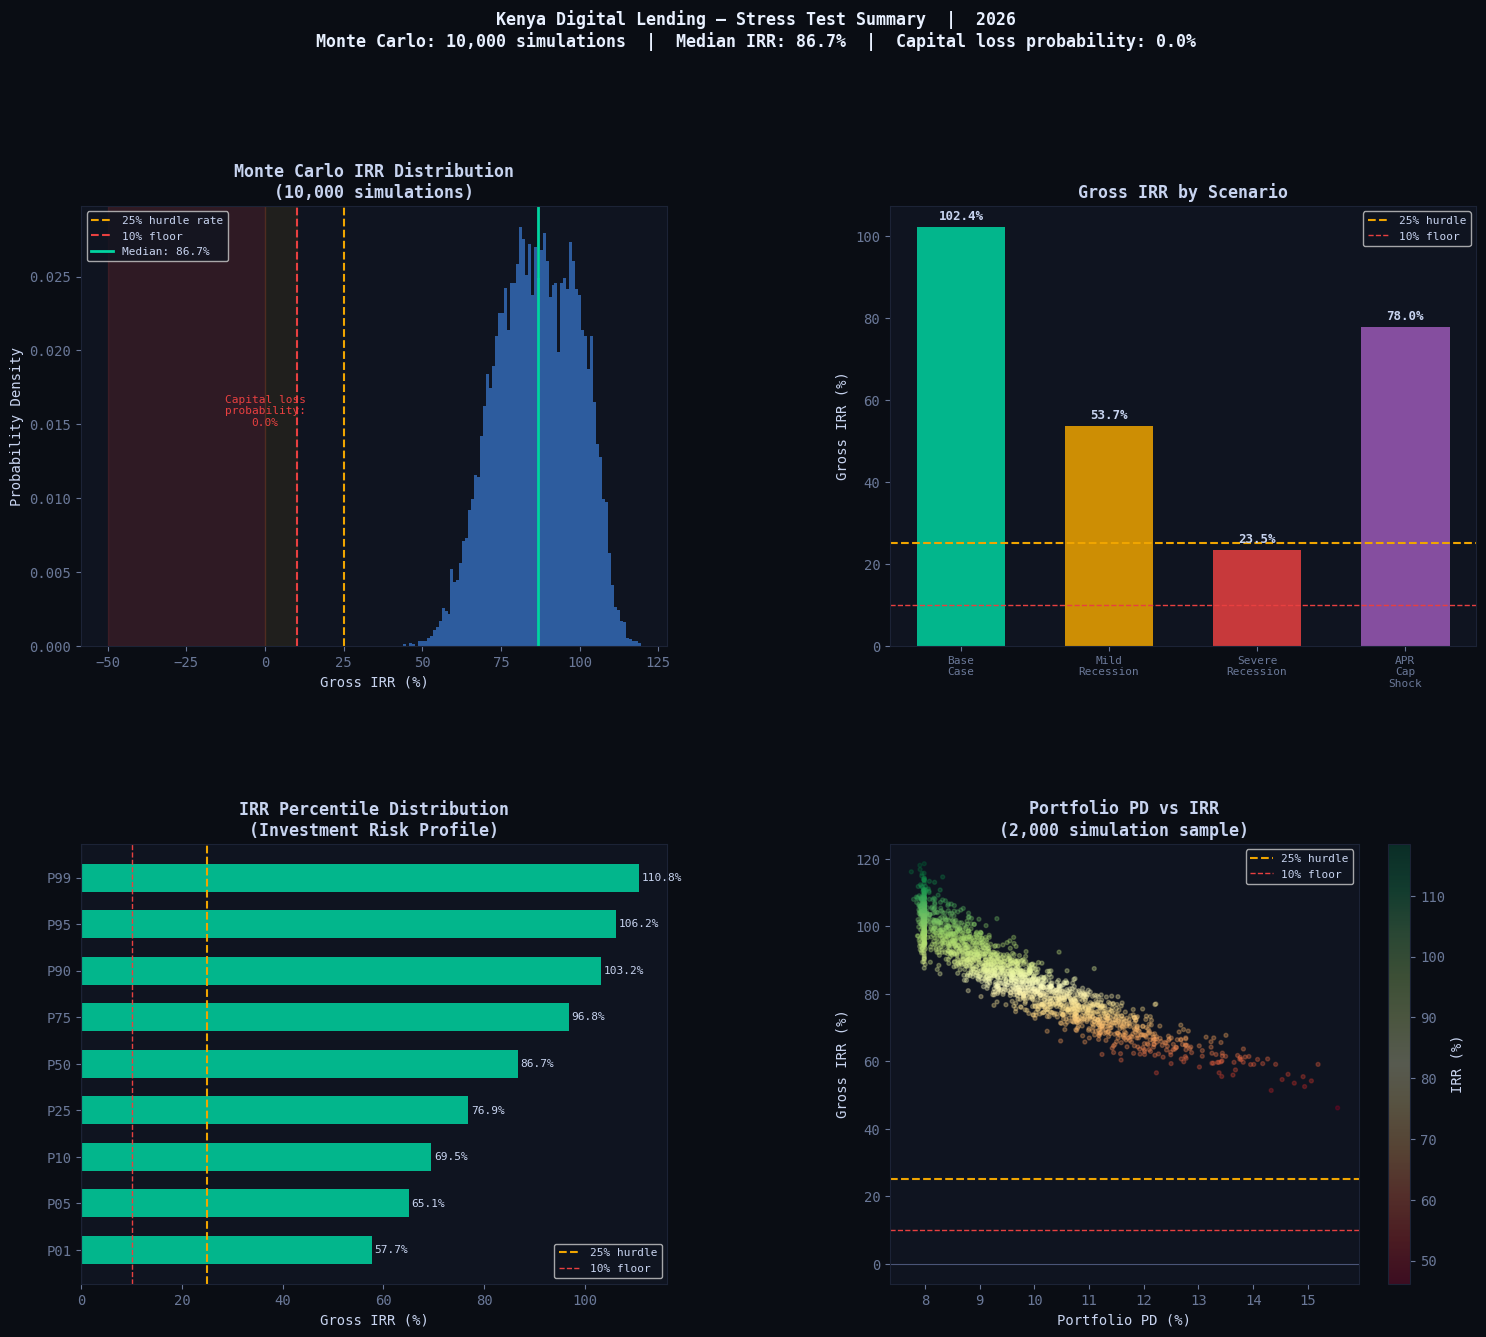

Chart saved: stress_test_summary.png


In [8]:
# ============================================================
# SECTION 4: VISUALISATION
# ============================================================

section("STRESS TEST VISUALISATION")

fig = plt.figure(figsize=(18, 14))
fig.patch.set_facecolor('#0a0d14')
gs = gridspec.GridSpec(2, 2, figure=fig,
                        hspace=0.45, wspace=0.38)

# ── Panel 1 — Monte Carlo IRR Distribution ───────────────
ax1 = fig.add_subplot(gs[0, 0])

ax1.hist(sim_irrs * 100, bins=80,
         color=COLORS['blue'], alpha=0.7,
         edgecolor='none', density=True)

# Shade tail regions
ax1.axvline(x=25, color=COLORS['amber'],
            linestyle='--', linewidth=1.5,
            label='25% hurdle rate')
ax1.axvline(x=10, color=COLORS['red'],
            linestyle='--', linewidth=1.5,
            label='10% floor')
ax1.axvline(x=median_irr*100,
            color=COLORS['green'],
            linestyle='-', linewidth=2,
            label=f'Median: {median_irr:.1%}')

# Shade loss zone
ax1.axvspan(ax1.get_xlim()[0] if ax1.get_xlim()[0] < 0 else -50,
            0, alpha=0.15, color=COLORS['red'])
ax1.axvspan(0, 10, alpha=0.08, color=COLORS['amber'])

ax1.set_title('Monte Carlo IRR Distribution\n'
              f'({N_SIMULATIONS:,} simulations)',
              fontweight='bold')
ax1.set_xlabel('Gross IRR (%)')
ax1.set_ylabel('Probability Density')
ax1.legend(fontsize=8)

# Add annotation
ax1.annotate(
    f'Capital loss\nprobability:\n{prob_loss:.1%}',
    xy=(0, ax1.get_ylim()[1]*0.5 if ax1.get_ylim()[1] > 0
        else 0.01),
    color=COLORS['red'], fontsize=8, ha='center'
)

# ── Panel 2 — Scenario Waterfall ─────────────────────────
ax2 = fig.add_subplot(gs[0, 1])

scenarios_plot = scenario_df['scenario'].tolist()
irrs_plot = (scenario_df['gross_irr'] * 100).tolist()
colors_plot = [COLORS['green'], COLORS['amber'],
               COLORS['red'], COLORS['purple']]

bars = ax2.bar(range(len(scenarios_plot)), irrs_plot,
               color=colors_plot, alpha=0.85, width=0.6)

ax2.axhline(y=25, color=COLORS['amber'],
            linestyle='--', linewidth=1.5,
            label='25% hurdle')
ax2.axhline(y=10, color=COLORS['red'],
            linestyle='--', linewidth=1,
            label='10% floor')

for bar, val in zip(bars, irrs_plot):
    ax2.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 1,
             f'{val:.1f}%',
             ha='center', va='bottom',
             fontsize=9, fontweight='bold',
             color='#c8d4f0')

ax2.set_xticks(range(len(scenarios_plot)))
ax2.set_xticklabels(
    [s.replace(' ', '\n') for s in scenarios_plot],
    fontsize=8
)
ax2.set_title('Gross IRR by Scenario',
              fontweight='bold')
ax2.set_ylabel('Gross IRR (%)')
ax2.legend(fontsize=8)

# ── Panel 3 — Risk Metrics Summary ───────────────────────
ax3 = fig.add_subplot(gs[1, 0])

percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
pct_values  = [np.percentile(sim_irrs*100, p)
               for p in percentiles]

colors_pct = [COLORS['red'] if v < 10
              else COLORS['amber'] if v < 25
              else COLORS['green']
              for v in pct_values]

bars3 = ax3.barh(
    [f'P{p:02d}' for p in percentiles],
    pct_values,
    color=colors_pct,
    alpha=0.85, height=0.6
)

ax3.axvline(x=25, color=COLORS['amber'],
            linestyle='--', linewidth=1.5,
            label='25% hurdle')
ax3.axvline(x=10, color=COLORS['red'],
            linestyle='--', linewidth=1,
            label='10% floor')
ax3.axvline(x=0, color=COLORS['muted'],
            linestyle='-', linewidth=0.8)

for bar, val in zip(bars3, pct_values):
    ax3.text(val + 0.5, bar.get_y() + bar.get_height()/2,
             f'{val:.1f}%',
             va='center', ha='left', fontsize=8,
             color='#c8d4f0')

ax3.set_title('IRR Percentile Distribution\n'
              '(Investment Risk Profile)',
              fontweight='bold')
ax3.set_xlabel('Gross IRR (%)')
ax3.legend(fontsize=8)

# ── Panel 4 — PD vs IRR Scatter ──────────────────────────
ax4 = fig.add_subplot(gs[1, 1])

sample_idx = np.random.choice(
    len(sim_irrs), 2000, replace=False
)

scatter = ax4.scatter(
    sim_pds[sample_idx] * 100,
    sim_irrs[sample_idx] * 100,
    c=sim_irrs[sample_idx] * 100,
    cmap='RdYlGn',
    alpha=0.3, s=8
)

ax4.axhline(y=25, color=COLORS['amber'],
            linestyle='--', linewidth=1.5,
            label='25% hurdle')
ax4.axhline(y=10, color=COLORS['red'],
            linestyle='--', linewidth=1,
            label='10% floor')
ax4.axhline(y=0, color=COLORS['muted'],
            linestyle='-', linewidth=0.8)

ax4.set_title('Portfolio PD vs IRR\n(2,000 simulation sample)',
              fontweight='bold')
ax4.set_xlabel('Portfolio PD (%)')
ax4.set_ylabel('Gross IRR (%)')
ax4.legend(fontsize=8)

plt.colorbar(scatter, ax=ax4, label='IRR (%)')

fig.suptitle(
    'Kenya Digital Lending — Stress Test Summary  |  2026\n'
    f'Monte Carlo: {N_SIMULATIONS:,} simulations  |  '
    f'Median IRR: {median_irr:.1%}  |  '
    f'Capital loss probability: {prob_loss:.1%}',
    fontsize=12, fontweight='bold', y=1.02,
    color='#e8f0ff'
)

plt.savefig(CHARTS + 'stress_test_summary.png',
            dpi=150, bbox_inches='tight',
            facecolor='#0a0d14')
plt.show()
print("Chart saved: stress_test_summary.png")

In [10]:
# ============================================================
# SECTION 5: SAVE OUTPUTS
# ============================================================

section("SAVING OUTPUTS")

# Scenario results
scenario_df.to_csv(
    CLEAN + 'scenario_results.csv', index=False
)
print("✓ scenario_results.csv")

# Monte Carlo results
mc_results = pd.DataFrame({
    'simulation':    range(N_SIMULATIONS),
    'unemp_shock':   unemp_draws,
    'inflation_shock': inflation_draws,
    'rate_shock':    rate_draws,
    'stressed_pd':   sim_pds,
    'gross_irr':     sim_irrs,
    'net_irr':       sim_irrs * 0.70,
})
mc_results.to_csv(
    CLEAN + 'monte_carlo_results.csv', index=False
)
print("✓ monte_carlo_results.csv")

# Risk metrics summary
risk_metrics = pd.DataFrame({
    'metric': [
        'median_irr', 'mean_irr', 'p5_irr', 'p10_irr',
        'p25_irr', 'p75_irr', 'VaR_95', 'CVaR_95',
        'prob_below_25pct_hurdle', 'prob_below_10pct_floor',
        'prob_capital_loss', 'prob_above_50pct'
    ],
    'value': [
        median_irr, mean_irr, p5_irr, p10_irr,
        p25_irr, p75_irr, VaR_95, CVaR_95,
        prob_below_25, prob_below_10,
        prob_loss, prob_above_50
    ],
    'as_pct': [
        f'{v:.1%}' for v in [
            median_irr, mean_irr, p5_irr, p10_irr,
            p25_irr, p75_irr, VaR_95, CVaR_95,
            prob_below_25, prob_below_10,
            prob_loss, prob_above_50
        ]
    ]
})
risk_metrics.to_csv(
    CLEAN + 'risk_metrics_summary.csv', index=False
)
print("✓ risk_metrics_summary.csv")

print(f"""
╔══════════════════════════════════════════════════════════╗
║         NOTEBOOK 04 COMPLETE                            ║
╠══════════════════════════════════════════════════════════╣
║  Monte Carlo: {N_SIMULATIONS:,} simulations                     ║
║                                                          ║
║  Key risk metrics:                                       ║
║    Median IRR:              {median_irr:.1%}                    ║
║    5th percentile IRR:      {p5_irr:.1%}                    ║
║    Capital loss prob:       {prob_loss:.1%}                    ║
║                                                          ║
║  Decision criteria:                                      ║
║    Base IRR > 25%:          {'PASS' if median_irr > 0.25 else 'FAIL'}                      ║
║    Recession IRR > 10%:     {'PASS' if p5_irr > 0.10 else 'FAIL'}                      ║
║    Capital loss < 20%:      {'PASS' if prob_loss < 0.20 else 'FAIL'}                      ║
║                                                          ║
║  Outputs saved:                                          ║
║    scenario_results.csv                                  ║
║    monte_carlo_results.csv                               ║
║    risk_metrics_summary.csv                              ║
║    stress_test_summary.png                               ║
║                                                          ║
║  Next: Tableau Dashboard                                 ║
╚══════════════════════════════════════════════════════════╝
""")


  SAVING OUTPUTS
✓ scenario_results.csv
✓ monte_carlo_results.csv
✓ risk_metrics_summary.csv

╔══════════════════════════════════════════════════════════╗
║         NOTEBOOK 04 COMPLETE                            ║
╠══════════════════════════════════════════════════════════╣
║  Monte Carlo: 10,000 simulations                     ║
║                                                          ║
║  Key risk metrics:                                       ║
║    Median IRR:              86.7%                    ║
║    5th percentile IRR:      65.1%                    ║
║    Capital loss prob:       0.0%                    ║
║                                                          ║
║  Decision criteria:                                      ║
║    Base IRR > 25%:          PASS                      ║
║    Recession IRR > 10%:     PASS                      ║
║    Capital loss < 20%:      PASS                      ║
║                                                          ║
║  Outputs saved: